# Financial Accounting EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import f_oneway

In [2]:
df = pd.read_csv('../data/double_entry_financial_accounting.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
#Only use data from accounting period 2022
df['Date'] = df['Date'] - pd.DateOffset(years=1)
df = df[df['Date'].dt.year == 2022]
df.rename(columns={'Transaction_Type': 'Transaction Type'}, inplace=True)

In [4]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              200000 non-null  datetime64[ns]
 1   Account           200000 non-null  object        
 2   Debit             200000 non-null  float64       
 3   Credit            200000 non-null  float64       
 4   Category          200000 non-null  object        
 5   Transaction Type  200000 non-null  object        
 6   Customer_Vendor   200000 non-null  object        
 7   Payment_Method    200000 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 13.7+ MB
None


,Date,Account,Debit,Credit,Category,Transaction Type,Customer_Vendor,Payment_Method
0,2022-03-15,Accounts Receivable,274.79,0.00,Asset,Transfer,Customer 47,Cash
1,2022-03-15,Expense Account,0.00,274.79,Expense,Transfer,Customer 47,Cash
2,2022-12-06,Accounts Receivable,777.34,0.00,Asset,Sale,Customer 9,Credit Card
3,2022-12-06,Liability Account,0.00,777.34,Liability,Sale,Customer 9,Credit Card
4,2022-04-16,Accounts Receivable,566.85,0.00,Asset,Sale,Customer 2,Credit Card


In [5]:
print(df['Transaction Type'].unique())
print(df['Category'].unique())
print(df['Payment_Method'].unique())
print(df['Account'].unique())

['Transfer' 'Sale' 'Expense' 'Purchase']
['Asset' 'Expense' 'Liability' 'Revenue']
['Cash' 'Credit Card' 'Check' 'Bank Transfer']
['Accounts Receivable' 'Expense Account' 'Liability Account'
 'Asset Account' 'Sales Revenue' 'Accounts Payable' 'Inventory' 'Cash'
 'Revenue Account']


## Transaction Analysis

### How many transactions are in each category?

Text(0.5, 1.0, 'Transaction Volume by Category')

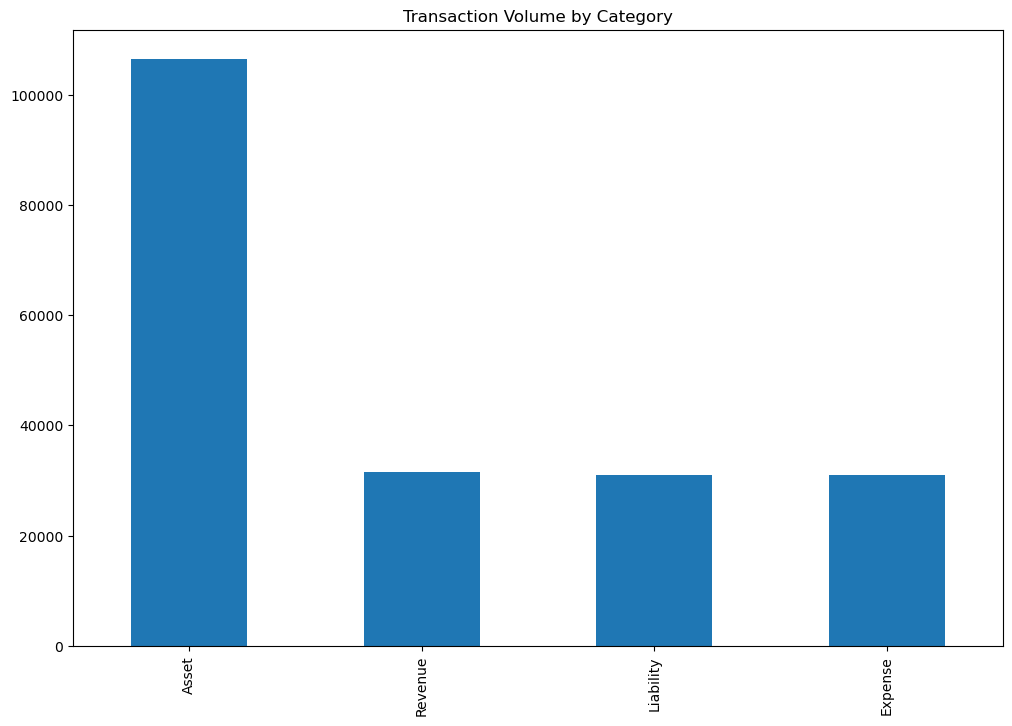

In [6]:
df['Category'].value_counts().plot(kind='bar', figsize=(12, 8))
plt.title('Transaction Volume by Category')

### How does the transaction volume change month-to-month?

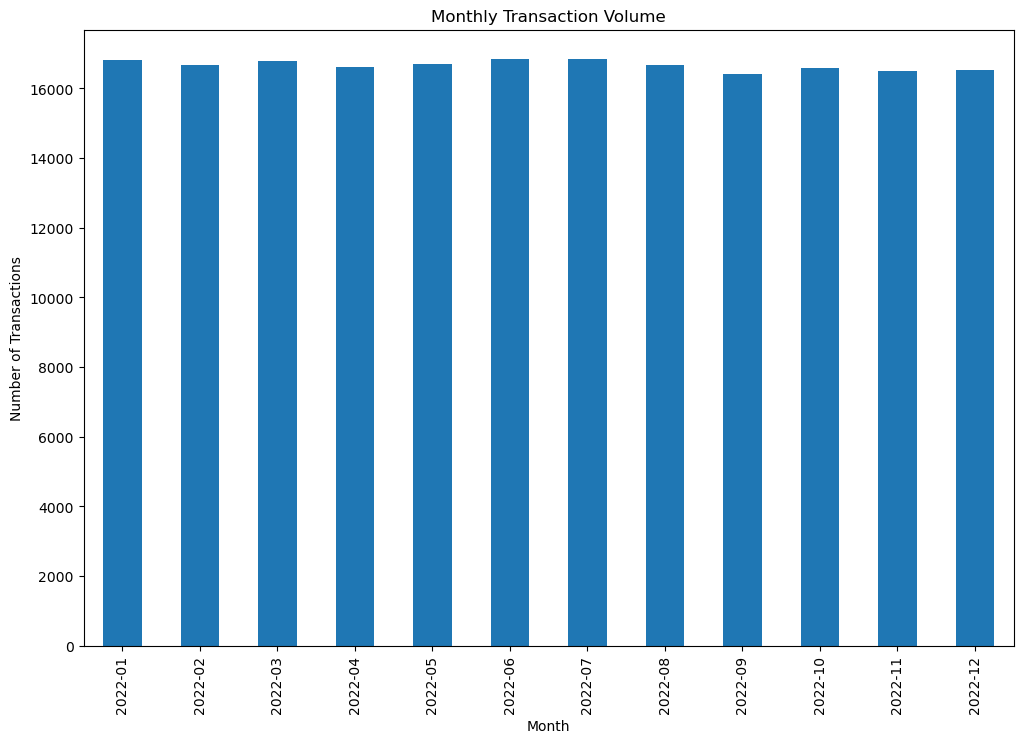

ANOVA Test Results
F-Value: 0.2378371657152704, P-Value: 0.9948882186765989
There is no statistically significant difference in transactions volume month-to-month.


In [7]:
transaction_volume = df.groupby(df['Date'].dt.to_period('M')).size()

transaction_volume.plot(kind='bar', figsize=(12, 8))
plt.title('Monthly Transaction Volume')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

monthly_transactions = [df[df['Month'] == month]['Debit'] for month in df['Month'].unique()]
f_value, p_value = stats.f_oneway(*monthly_transactions)
print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in transactions volume month-to-month.")
else:
    print("There is no statistically significant difference in transactions volume month-to-month.")
df.reset_index(inplace=True)
df.drop(columns=['Month'], inplace=True)

### Distribution of Transaction Volume by Transaction Type

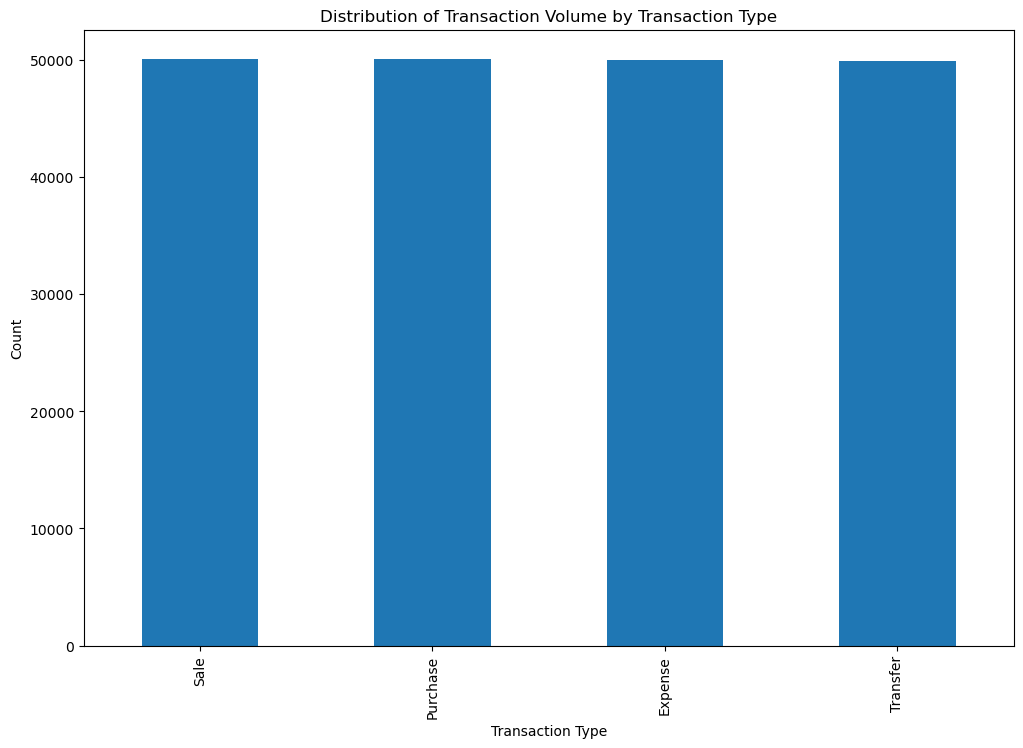

Chi-Square Test Results
Chi-Square Statistic: 0.36144, P-Value: 0.9480876689583654
There is no statistically significant difference in the transaction volume by transaction type.


In [8]:
transaction_type_counts = df['Transaction Type'].value_counts()

transaction_type_counts.plot(kind='bar', figsize=(12, 8))
plt.title('Distribution of Transaction Volume by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

total_count = sum(transaction_type_counts)
num_categories = len(transaction_type_counts)
expected_counts = [total_count / num_categories] * num_categories
chi_square_stat, p_value = stats.chisquare(f_obs=transaction_type_counts, f_exp=expected_counts)

print("Chi-Square Test Results")
print(f"Chi-Square Statistic: {chi_square_stat}, P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in the transaction volume by transaction type.")
else:
    print("There is no statistically significant difference in the transaction volume by transaction type.")

### Histogram of transaction amounts by transaction type

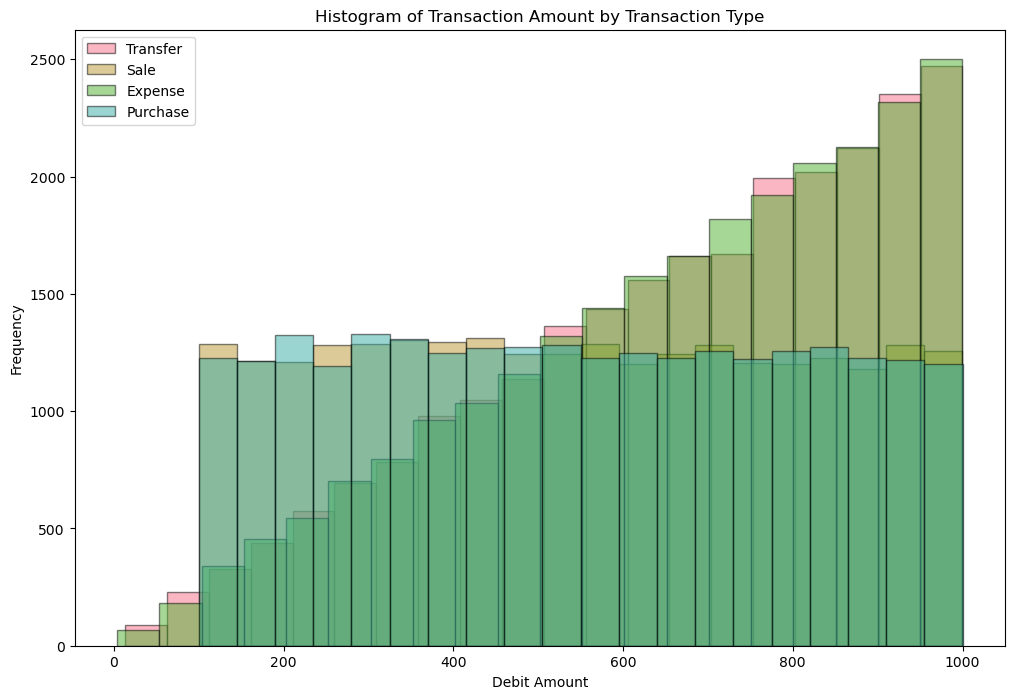

In [9]:
palette = sns.color_palette("husl")
plt.figure(figsize=(12, 8))

for transaction_type, color in zip(df['Transaction Type'].unique(), palette):
    dept_df = df[(df['Transaction Type'] == transaction_type) & (df['Debit'] > 0)]
    plt.hist(dept_df['Debit'], bins=20, alpha=0.5, label=transaction_type, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Transaction Amount by Transaction Type')
plt.xlabel('Debit Amount')
plt.ylabel('Frequency')
plt.show()

In [10]:
filtered_df = df[df['Debit'] > 0]
f_value, p_value = stats.f_oneway(filtered_df[filtered_df['Transaction Type'] == 'Transfer']['Debit'],
                                   filtered_df[filtered_df['Transaction Type'] == 'Sale']['Debit'],
                                   filtered_df[filtered_df['Transaction Type'] == 'Expense']['Debit'],
                                   filtered_df[filtered_df['Transaction Type'] == 'Purchase']['Debit'])

print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of transaction amounts by transaction type.")
    print("Post-Hoc Analysis (Tukey's HSD Test):")
    mc = MultiComparison(filtered_df['Debit'], filtered_df['Category'])
    result = mc.tukeyhsd() 
    print(result)
else:
    print("There is no statistically significant difference in the distribution of transaction amounts by transaction type.")

ANOVA Test Results
F-Value: 1980.734260468001, P-Value: 0.0
There is a statistically significant difference in the distribution of transaction amounts by transaction type.
Post-Hoc Analysis (Tukey's HSD Test):
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
    Asset   Expense   0.6983 0.9883  -4.8488 6.2453  False
    Asset Liability  -4.0078  0.245  -9.5405 1.5248  False
    Asset   Revenue  -7.0032 0.1624 -15.6879 1.6816  False
  Expense Liability  -4.7061 0.2837 -11.5044 2.0922  False
  Expense   Revenue  -7.7014 0.1617 -17.2425 1.8396  False
Liability   Revenue  -2.9954 0.8511 -12.5281 6.5373  False
----------------------------------------------------------


### Histogram of transaction amounts by category

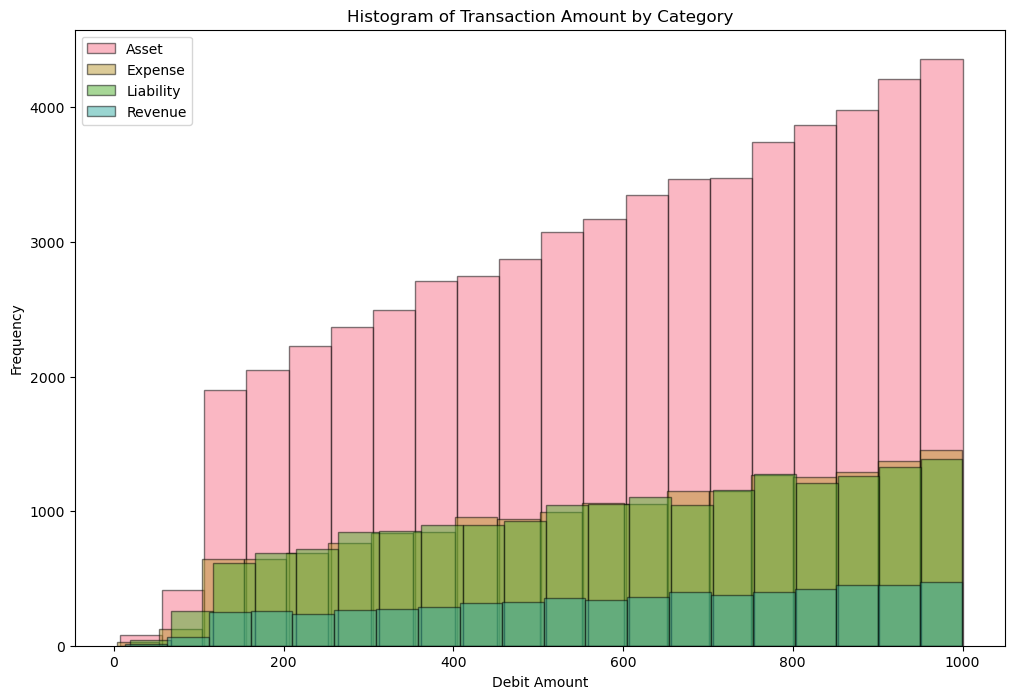

In [11]:
palette = sns.color_palette("husl")
plt.figure(figsize=(12, 8))

for category, color in zip(df.Category.unique(), palette):
    dept_df = df[(df['Category'] == category) & (df['Debit'] > 0)]
    plt.hist(dept_df['Debit'], bins=20, alpha=0.5, label=category, color=color, edgecolor='black')

plt.legend()
plt.title('Histogram of Transaction Amount by Category')
plt.xlabel('Debit Amount')
plt.ylabel('Frequency')
plt.show()

### Further comparison of the distribution of transaction amounts by category

In [12]:
filtered_df = df[df['Debit'] > 0]
f_value, p_value = stats.f_oneway(filtered_df[filtered_df['Category'] == 'Asset']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Expense']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Liability']['Debit'],
                                   filtered_df[filtered_df['Category'] == 'Revenue']['Debit'])

print("ANOVA Test Results")
print(f"F-Value: {f_value}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant difference in the distribution of transaction amounts by category.")
    print("Post-Hoc Analysis (Tukey's HSD Test):")
    mc = MultiComparison(filtered_df['Debit'], filtered_df['Category'])
    result = mc.tukeyhsd() 
    print(result)
else:
    print("There is no statistically significant difference in the distribution of transaction amounts by category.")

ANOVA Test Results
F-Value: 2.594940296693603, P-Value: 0.05068056682278576
There is no statistically significant difference in the distribution of transaction amounts by category.


## Transaction Analysis by Account

### Transaction Volume by Account

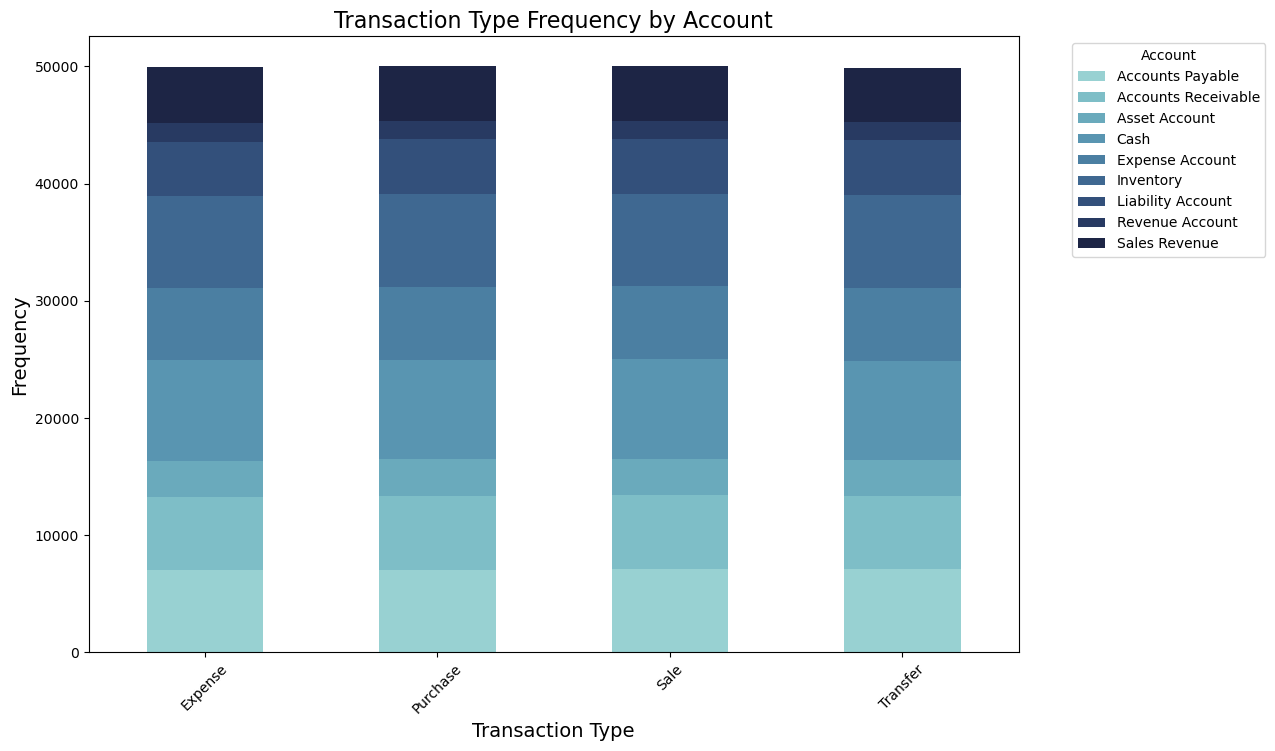

Chi-Square Test Results
Chi-Square Statistic: 8.371452888437618, P-Value: 0.9986641649404867
There is no statistically significant relationship between Account and volume per Transaction Type.


In [13]:
grouped_data = df.groupby(['Transaction Type', 'Account']).size().unstack(fill_value=0)
palette = sns.color_palette("ch:rot=-.25,hue=1,light=.75", n_colors=df.Account.nunique())
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=palette)
plt.title('Transaction Type Frequency by Account', fontsize=16)
plt.xlabel('Transaction Type', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Account', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

contingency_table = pd.crosstab(df['Account'], df['Transaction Type'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results")
print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")

if p < 0.05:
    print("There is a statistically significant relationship between Account and volume per Transaction Type.")
else:
    print("There is no statistically significant relationship between Account and volume per Transaction Type.")

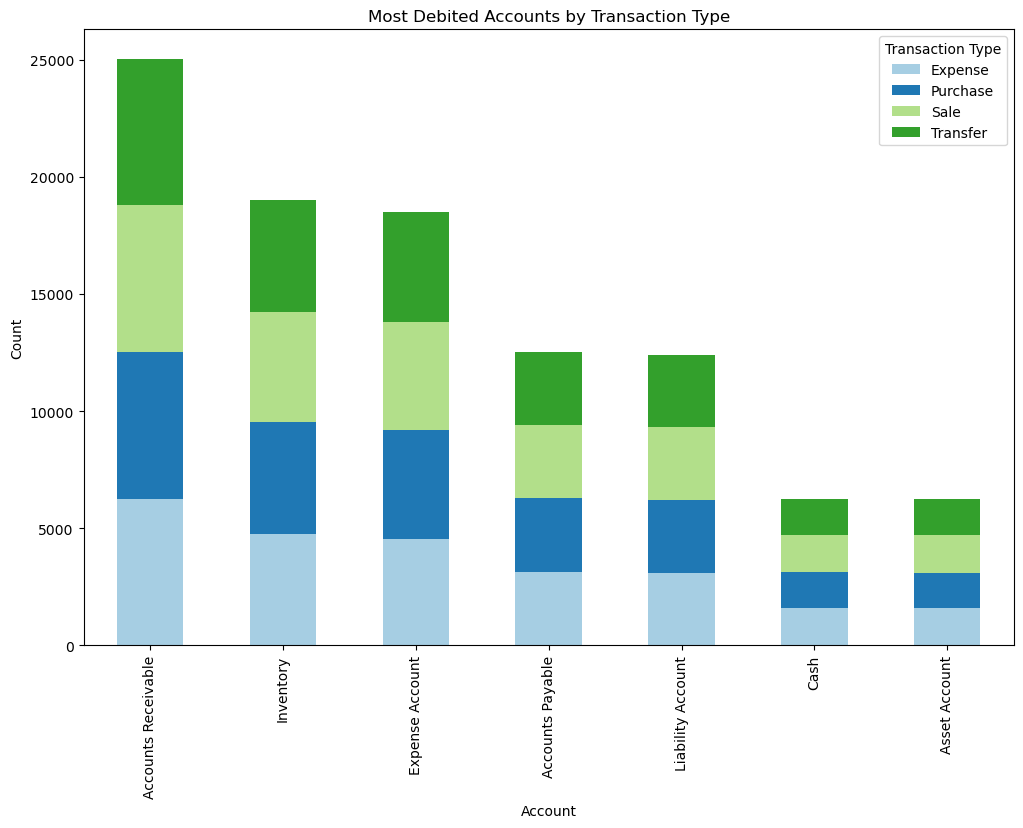

In [14]:
debited_df = df[df['Debit'] > 0]

grouped = debited_df.groupby(['Account', 'Transaction Type']).size().reset_index(name='Count')
pivot_df = grouped.pivot(index='Account', columns='Transaction Type', values='Count').fillna(0)
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df_sorted = pivot_df.sort_values(by='Total', ascending=False)
pivot_df_sorted = pivot_df_sorted.drop(columns=['Total'])

pivot_df_sorted.plot(kind='bar', stacked=True, figsize=(12, 8), color=sns.color_palette("Paired"))
plt.title('Most Debited Accounts by Transaction Type')
plt.xlabel('Account')
plt.ylabel('Count')
plt.legend(title='Transaction Type')
plt.show()

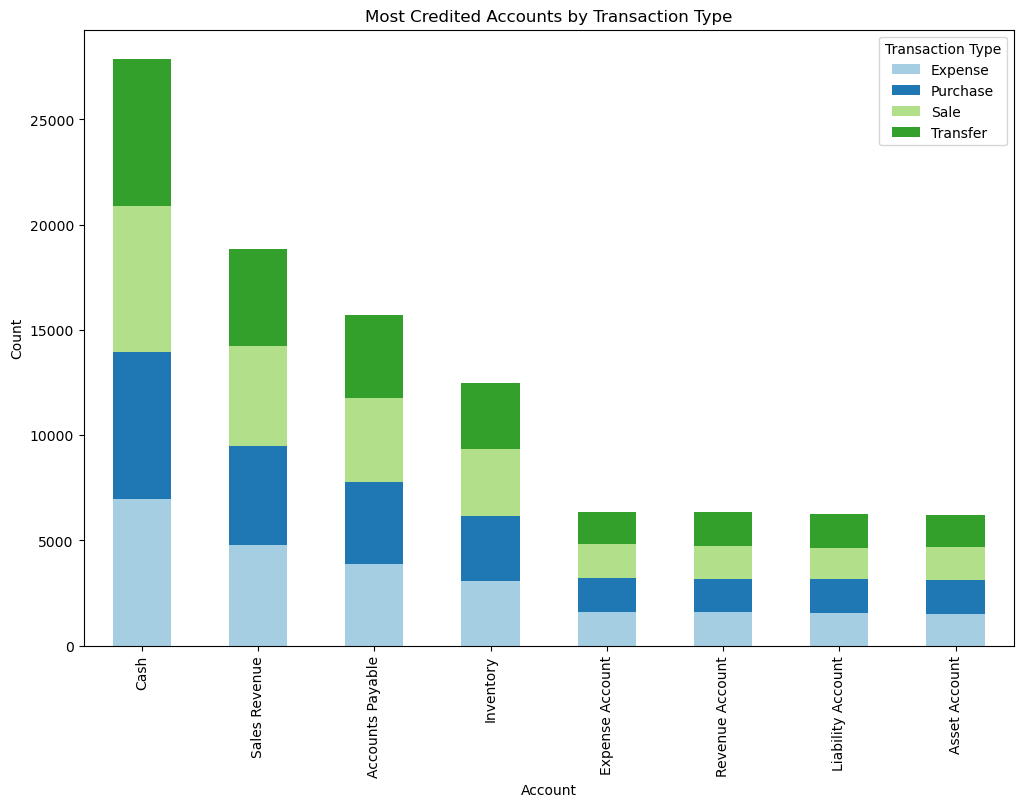

In [15]:
debited_df = df[df['Credit'] > 0]

grouped = debited_df.groupby(['Account', 'Transaction Type']).size().reset_index(name='Count')
pivot_df = grouped.pivot(index='Account', columns='Transaction Type', values='Count').fillna(0)
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df_sorted = pivot_df.sort_values(by='Total', ascending=False)
pivot_df_sorted = pivot_df_sorted.drop(columns=['Total'])

pivot_df_sorted.plot(kind='bar', stacked=True, figsize=(12, 8), color=sns.color_palette("Paired"))
plt.title('Most Credited Accounts by Transaction Type')
plt.xlabel('Account')
plt.ylabel('Count')
plt.legend(title='Transaction Type')
plt.show()

## Customer Transaction Analysis

In [16]:
df['Customer_Vendor'].nunique()

100

### Does transaction volume vary by customer?

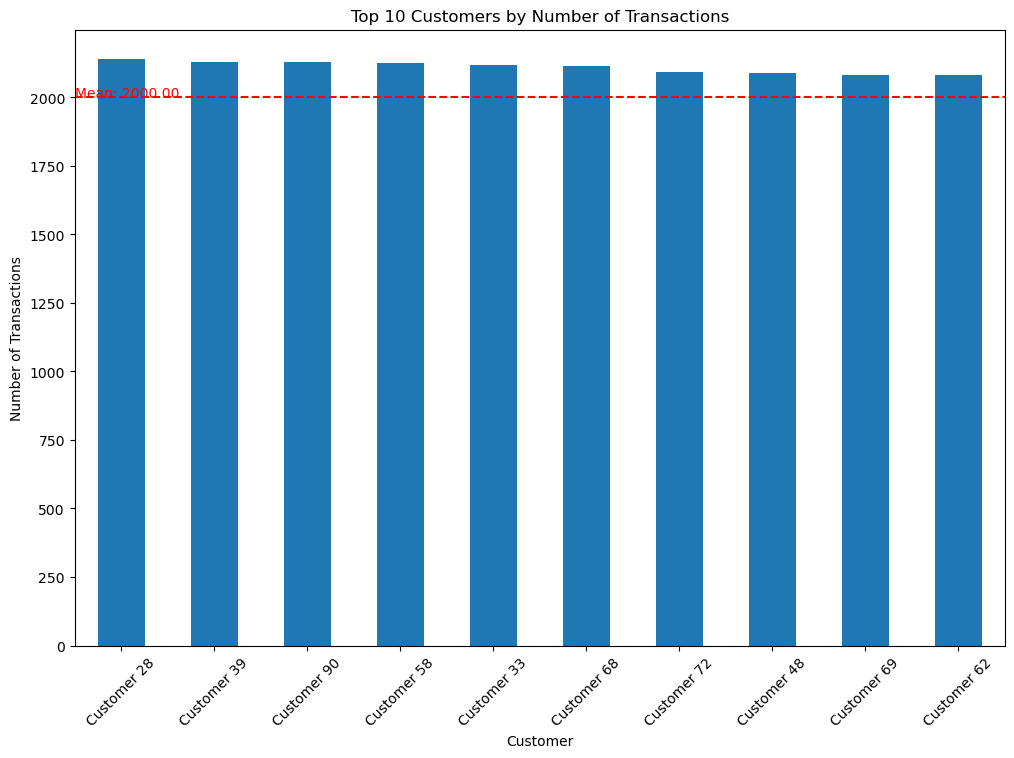

Chi-Square Test p-value: 1.0
There is no significant difference in transaction volumes between customers.


In [17]:
customer_transaction_counts = df['Customer_Vendor'].value_counts()
mean_transaction_count = df['Customer_Vendor'].value_counts().mean()

plt.figure(figsize=(12, 8))
customer_transaction_counts.head(10).plot(kind='bar')
plt.title('Top 10 Customers by Number of Transactions')
plt.xlabel('Customer')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

plt.axhline(y=mean_transaction_count, color='red', linestyle='--')
plt.text(x=-0.5, y=mean_transaction_count + 1, s=f'Mean: {mean_transaction_count:.2f}', color='red')
plt.show()


contingency_table = pd.DataFrame(customer_transaction_counts)
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test p-value:", p)
if p < 0.05:
    print("There is a significant difference in transaction volumes between customers.")
else:
    print("There is no significant difference in transaction volumes between customers.")

### Does transaction amount vary by customer?

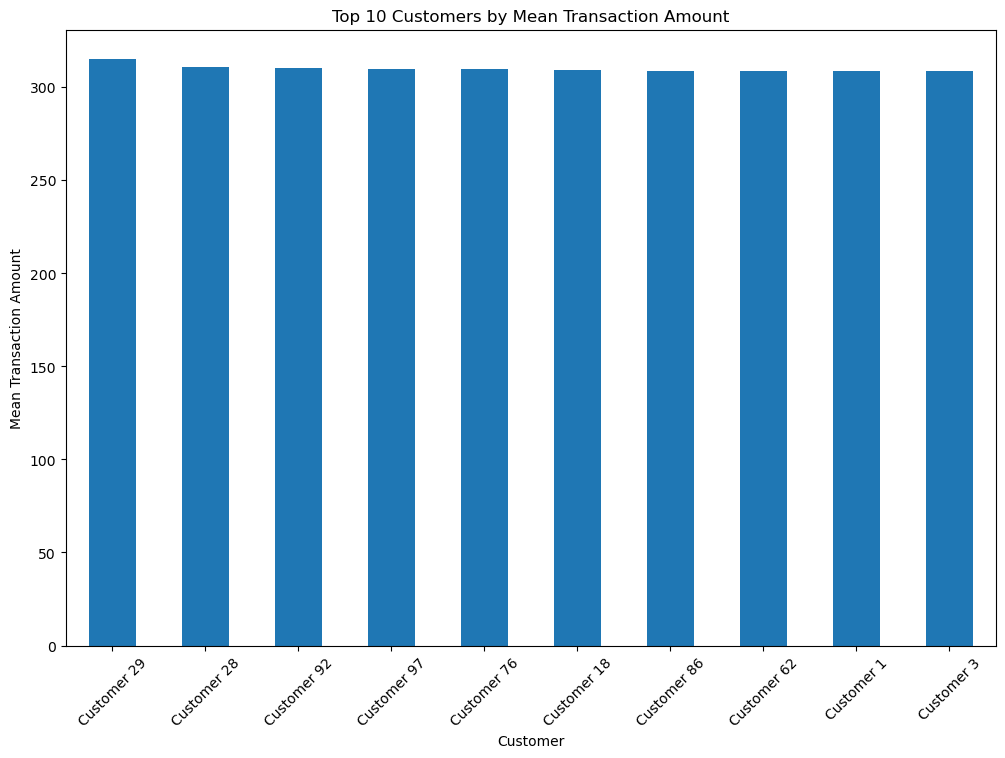

ANOVA Test p-value: 0.9999999999999999
There is no significant difference in mean transaction amounts between customers.


In [18]:
mean_transaction_amounts = df.groupby('Customer_Vendor')['Debit'].mean()

plt.figure(figsize=(12, 8))
mean_transaction_amounts.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Customers by Mean Transaction Amount')
plt.xlabel('Customer')
plt.ylabel('Mean Transaction Amount')
plt.xticks(rotation=45)
plt.show()

# ANOVA Test
groups = [group['Debit'].values for name, group in df.groupby('Customer_Vendor') if len(group['Debit']) > 1]

f_stat, p_val = f_oneway(*groups)
print("ANOVA Test p-value:", p_val)

# Interpretation
if p_val < 0.05:
    print("There is a significant difference in mean transaction amounts between customers.")
else:
    print("There is no significant difference in mean transaction amounts between customers.")

## Payment Methods

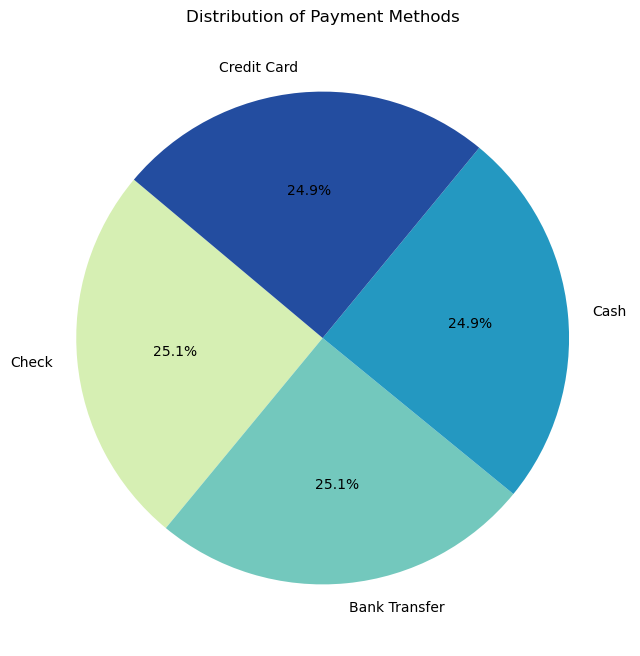

In [19]:
payment_method_counts = df['Payment_Method'].value_counts()
colors = sns.color_palette('YlGnBu', len(payment_method_counts))
plt.figure(figsize=(8, 8))
plt.pie(payment_method_counts, labels=payment_method_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Payment Methods')
plt.ylabel('')
plt.show()

### Does transaction volume vary by payment method over the accounting period?

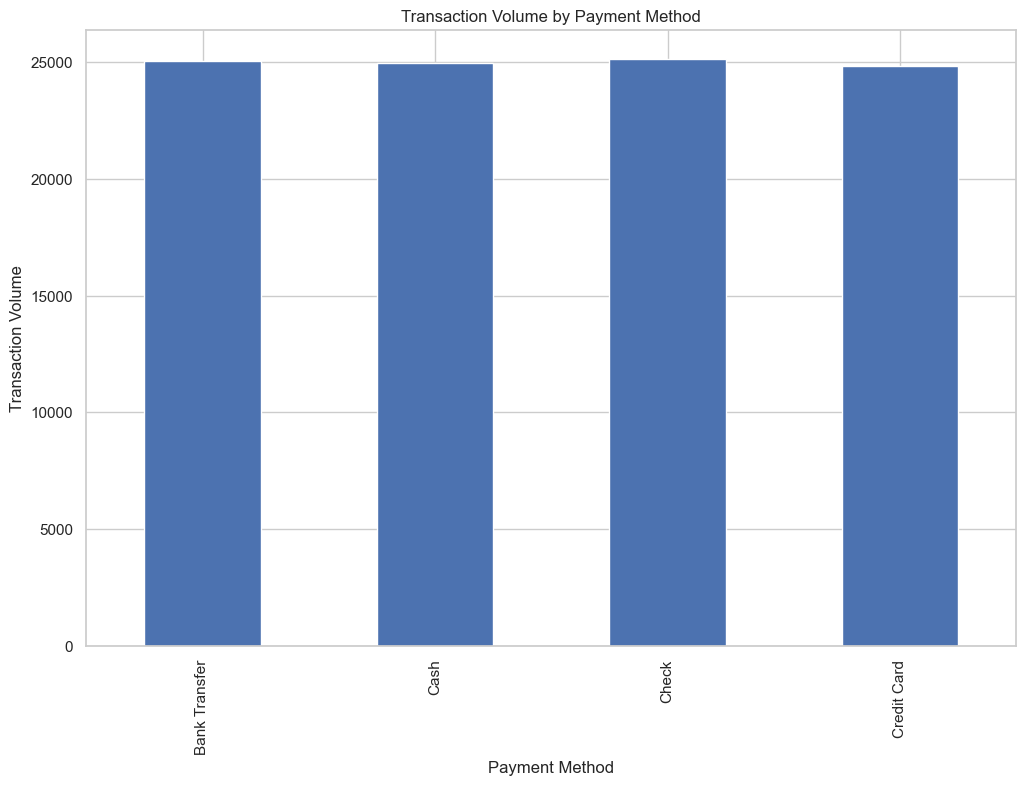

ANOVA Test Results - P-Value: 0.2329148038784857
There is no statistically significant relationship between payment method and transaction volume over accounting period.


In [34]:
filtered_df = df[df['Debit'] > 0]

grouped = filtered_df.groupby('Payment_Method')['Debit'].count()
grouped.plot(kind='bar', figsize=(12, 8))
groups = [group['Debit'].values for name, group in filtered_df.groupby('Payment_Method')]
plt.title('Transaction Volume by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Transaction Volume')
plt.show()

f_stat, p_val = f_oneway(*groups)

print("ANOVA Test Results - P-Value:", p_val)

alpha = 0.05
if p_val < alpha:
    print("There is a statistically significant relationship between payment method and transaction volume over accounting period.")
else:
    print("There is no statistically significant relationship between payment method and transaction volume over accounting period.")

### Does transaction volume vary by payment method month-to-month?

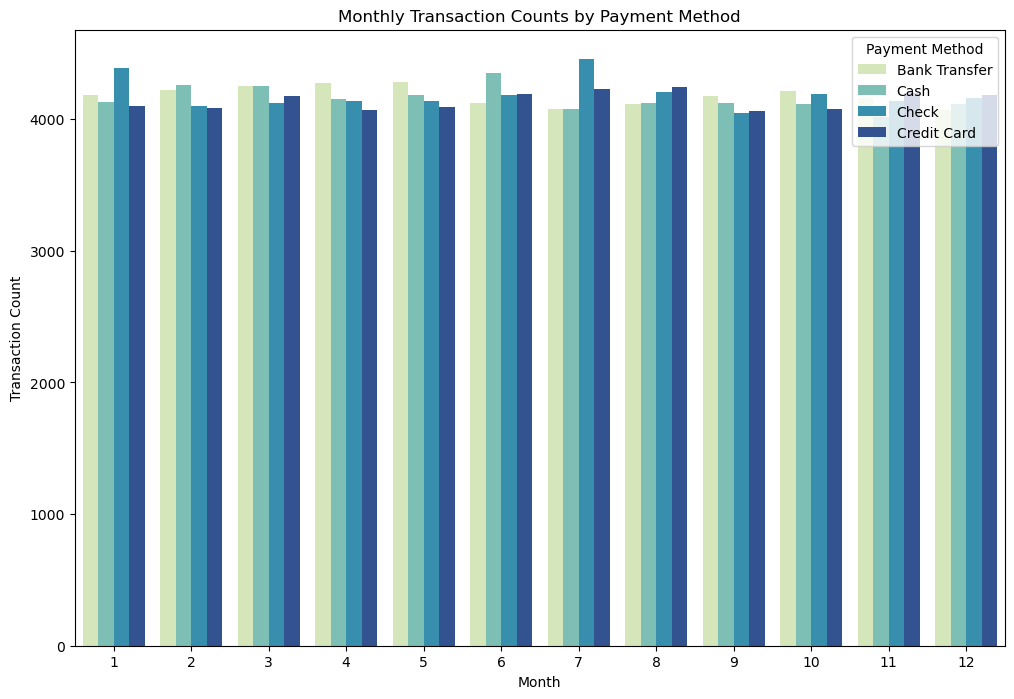

Chi-Square Test of Independence Results
Chi-Square Statistic: 0.36144, P-Value: 0.05068056682278576
There is no statistically significant relationship between month and payment method.


In [20]:
df['Month'] = df['Date'].dt.month
contingency_table = pd.crosstab(df['Month'], df['Payment_Method'])

long_form = contingency_table.reset_index().melt(id_vars='Month', var_name='Payment_Method', value_name='Count')
plt.figure(figsize=(12, 8))
sns.barplot(x='Month', y='Count', hue='Payment_Method', data=long_form, palette=colors)

plt.title('Monthly Transaction Counts by Payment Method')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.legend(title='Payment Method')
plt.show()


print("Chi-Square Test of Independence Results")
print(f"Chi-Square Statistic: {chi_square_stat}, P-Value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant relationship between month and payment method.")
else:
    print("There is no statistically significant relationship between month and payment method.")

### Is there a relationship between payment method and mean transaction amount?

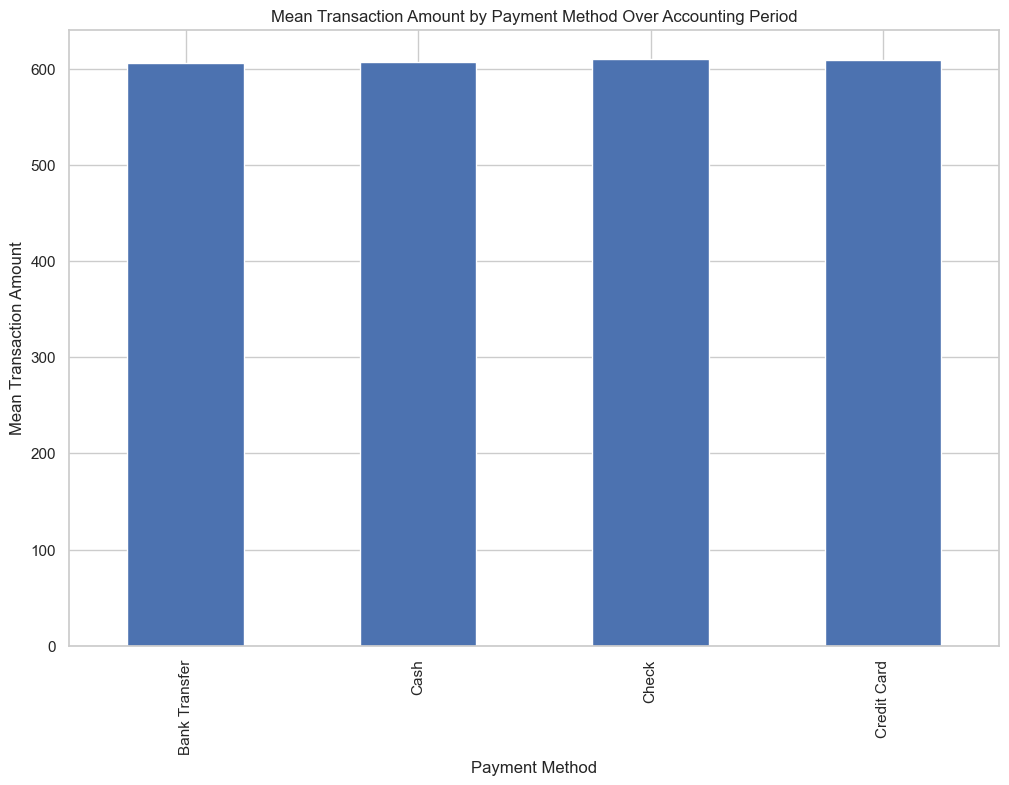

ANOVA Test Results - P-Value: 0.2329148038784857
There is no statistically significant relationship between payment method and mean transaction amount.


In [35]:
filtered_df = df[df['Debit'] > 0]

grouped = filtered_df.groupby('Payment_Method')['Debit'].mean()
grouped.plot(kind='bar', figsize=(12, 8))
groups = [group['Debit'].values for name, group in filtered_df.groupby('Payment_Method')]
plt.title('Mean Transaction Amount by Payment Method Over Accounting Period')
plt.xlabel('Payment Method')
plt.ylabel('Mean Transaction Amount')
plt.show()

f_stat, p_val = f_oneway(*groups)

print("ANOVA Test Results - P-Value:", p_val)

alpha = 0.05
if p_val < alpha:
    print("There is a statistically significant relationship between payment method and mean transaction amount.")
else:
    print("There is no statistically significant relationship between payment method and mean transaction amount.")

### Is there a relationship between transaction type and payment method?

In [22]:
cross_tab = pd.crosstab(df['Transaction Type'], df['Payment_Method'])
chi2, p_value, dof, expected = stats.chi2_contingency(cross_tab)
print("Chi-Square Test Result:", p_value)

if p_value < 0.05:
    print("There is a statistically significant relationship between transaction type and payment method.")
else:
    print("There is no statistically significant relationship between transaction type and payment method.")

Chi-Square Test Result: 0.20615039666510257
There is no statistically significant relationship between transaction type and payment method.


## Categorical Analysis

Text(0, 0.5, 'Transaction Volume')

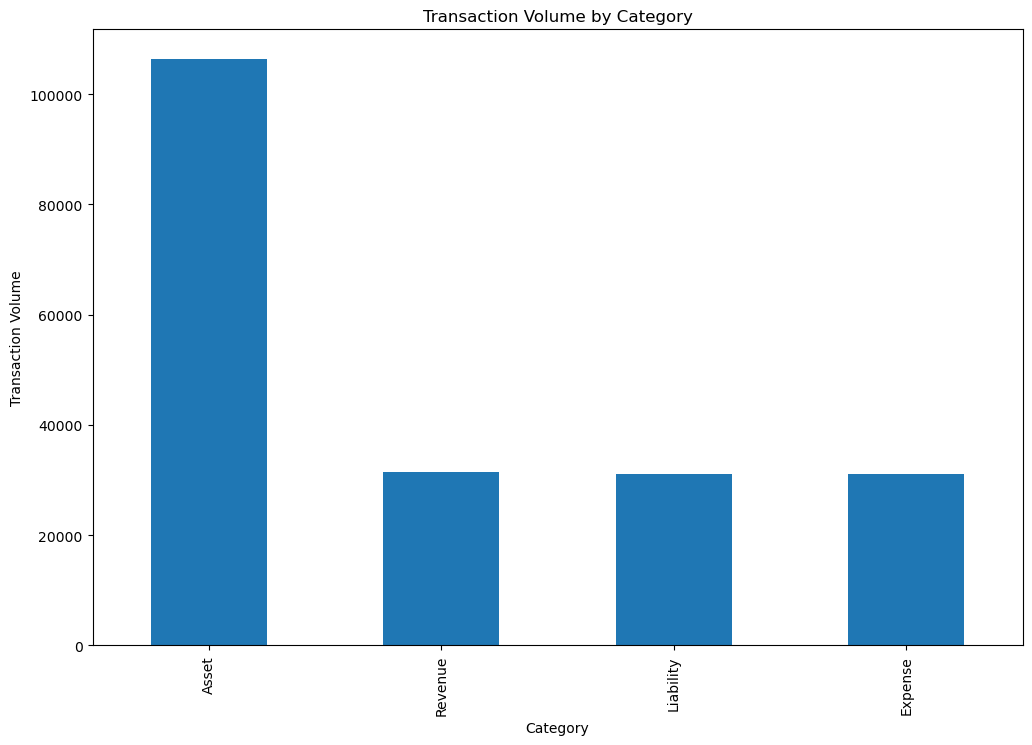

In [23]:
df['Category'].value_counts().plot(kind='bar', figsize=(12, 8))
plt.title('Transaction Volume by Category')
plt.xlabel('Category')
plt.ylabel('Transaction Volume')

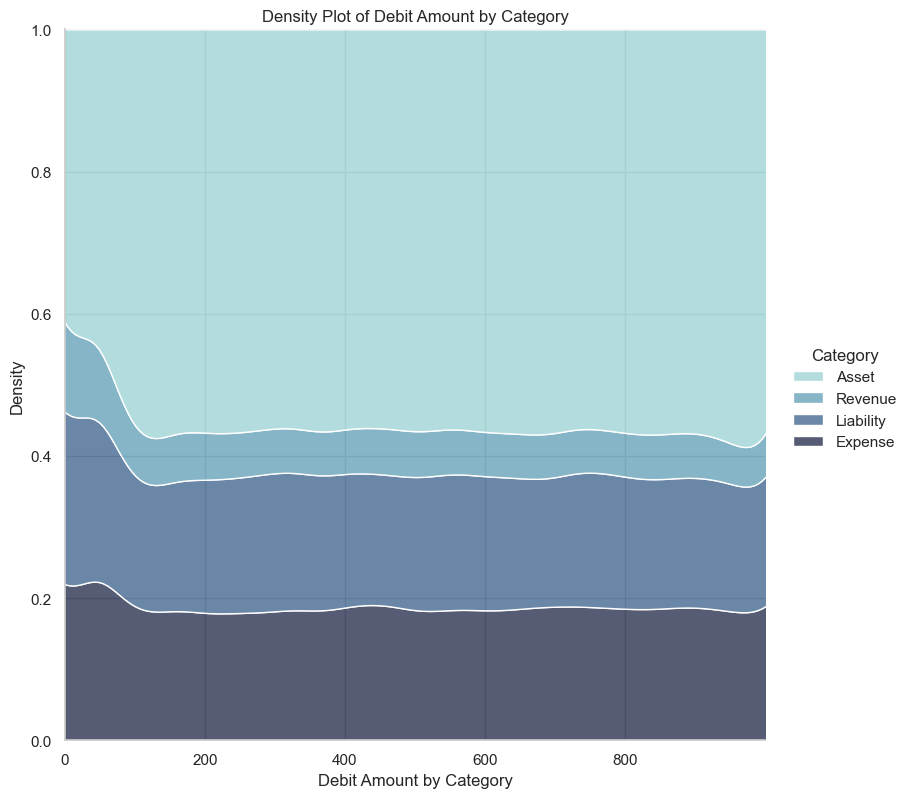

In [48]:
debits_df = df[(df['Debit'] > 0)]
sns.set_theme(style="whitegrid")
g = sns.displot(data=debits_df, x='Debit', hue='Category', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Density Plot of Debit Amount by Category')
plt.xlabel('Debit Amount by Category')
plt.ylabel('Density')
plt.xlim(0, debits_df['Debit'].max())
plt.show()

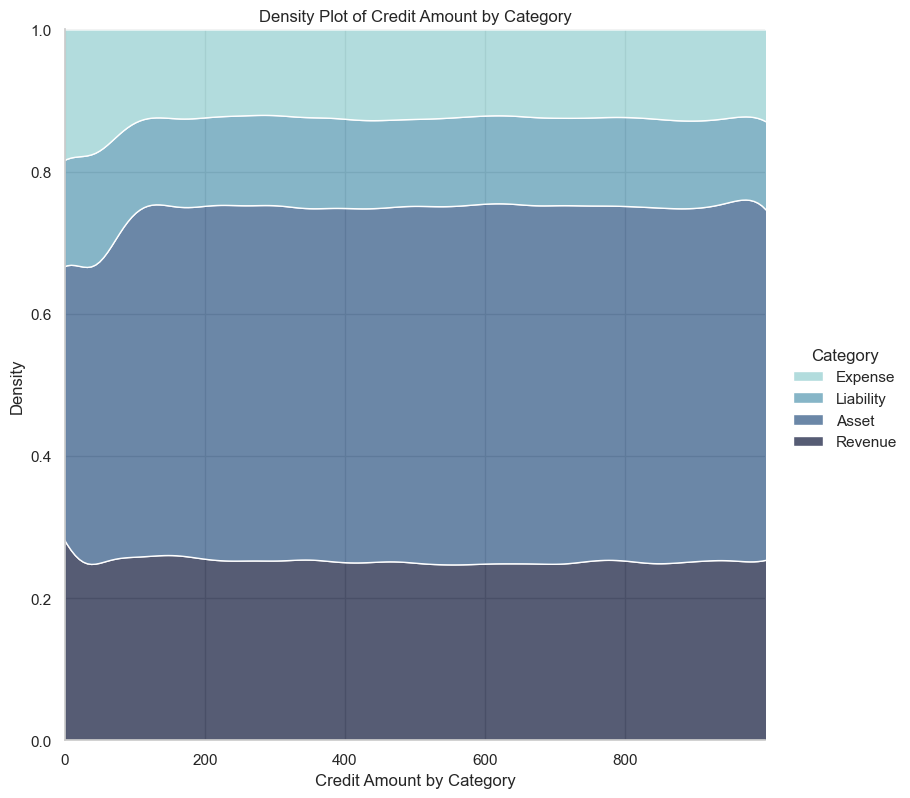

In [46]:
credits_df = df[(df['Credit'] > 0)]
sns.set_theme(style="whitegrid")
g = sns.displot(data=credits_df, x='Credit', hue='Category', kind='kde', multiple="fill",
                palette="ch:rot=-.25,hue=1,light=.75", height=8)
plt.title('Density Plot of Credit Amount by Category')
plt.xlabel('Credit Amount by Category')
plt.ylabel('Density')
plt.xlim(0, credits_df['Credit'].max())
plt.show()

## Debit and Credit Analysis per Account

**Debit**: An accounting entry that either increases an asset or expense account, or decreases a liability or equity account.<br>
**Credit**: An accounting entry that either increases a liability or equity account, or decreases an asset or expense account.

*Per [AccountingTools](https://www.accountingtools.com/articles/debits-and-credits)*

In [26]:
account_totals = df.groupby('Account').agg({'Debit': 'sum', 'Credit': 'sum'})

### Debits

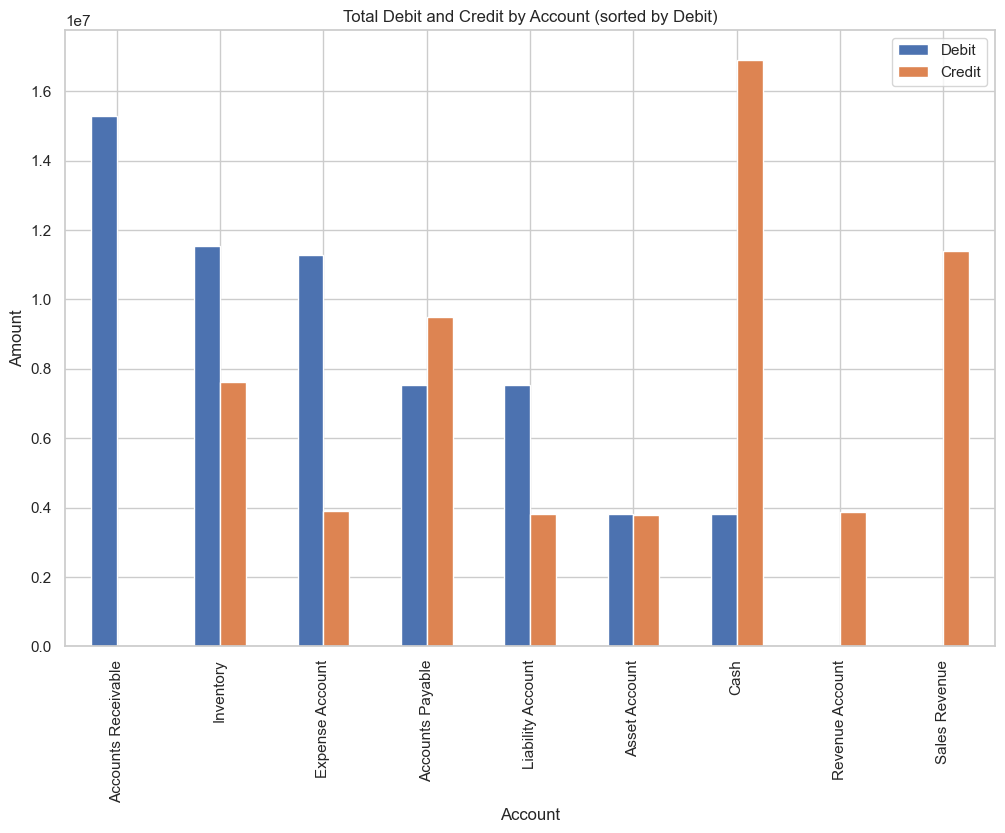

In [27]:
account_totals.sort_values(by='Debit', ascending=False, inplace=True)
account_totals.plot(kind='bar', figsize=(12, 8))
plt.title('Total Debit and Credit by Account (sorted by Debit)')
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()

### Credits

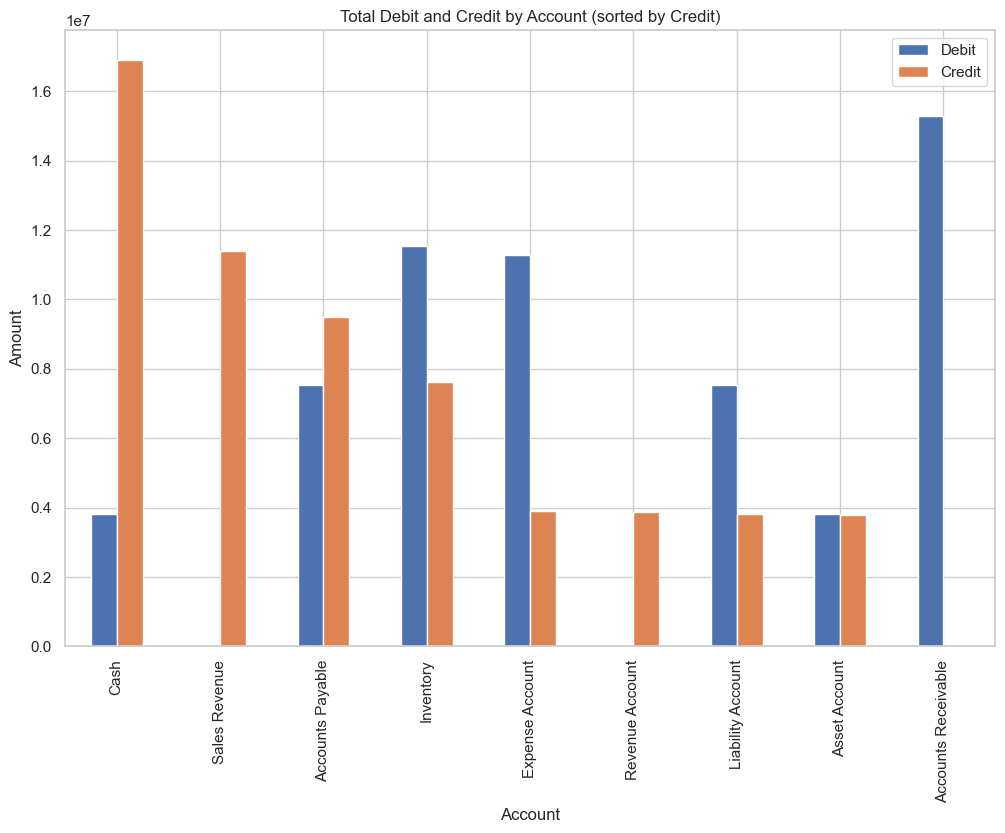

In [28]:
account_totals.sort_values(by='Credit', ascending=False, inplace=True)
account_totals.plot(kind='bar', figsize=(12, 8))
plt.title('Total Debit and Credit by Account (sorted by Credit)')
plt.xlabel('Account')
plt.ylabel('Amount')
plt.show()

## Statistical Questions

### Is there a difference in mean transaction amounts for different transaction types?

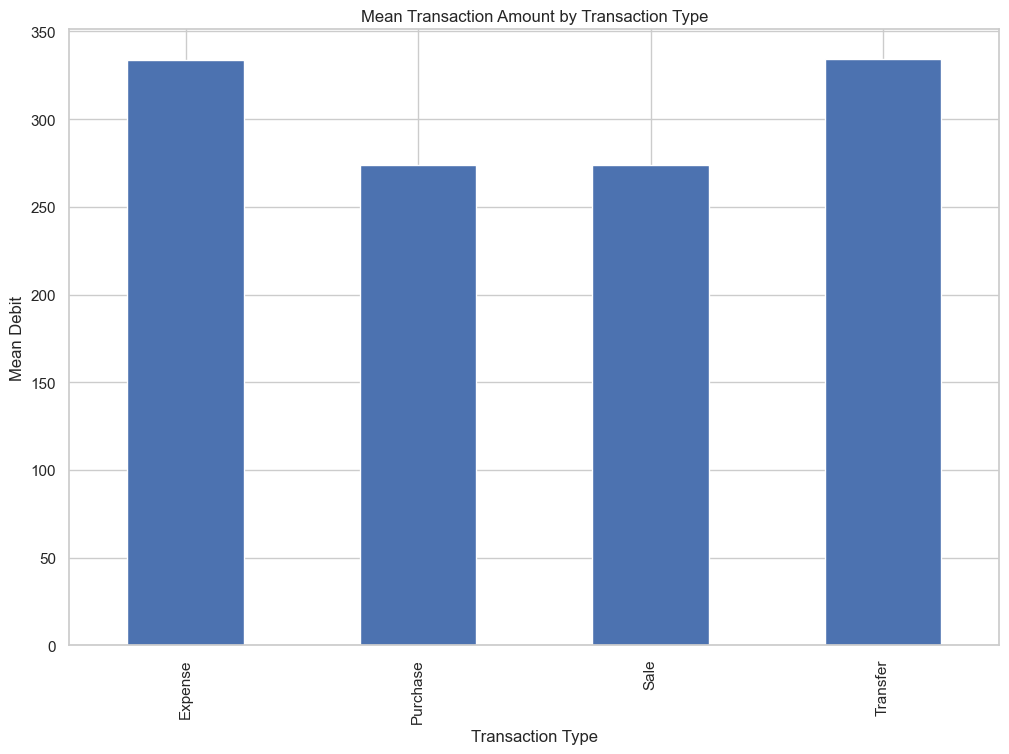

There is a statistically significant relationship between transaction type and payment method.


In [29]:
average_transaction_amounts = df.groupby('Transaction Type')['Debit'].mean()

f_value, p_value = stats.f_oneway(df[df['Transaction Type'] == 'Sale']['Debit'],
                               df[df['Transaction Type'] == 'Purchase']['Debit'],
                               df[df['Transaction Type'] == 'Transfer']['Debit'],
                               df[df['Transaction Type'] == 'Expense']['Debit'])


average_transaction_amounts.plot(kind='bar', figsize=(12, 8))
plt.title('Mean Transaction Amount by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Mean Debit')
plt.show()

if p_value < 0.05:
    print("There is a statistically significant relationship between transaction type and payment method.")
else:
    print("There is no statistically significant relationship between transaction type and payment method.")


### Revenue and expenses over the year

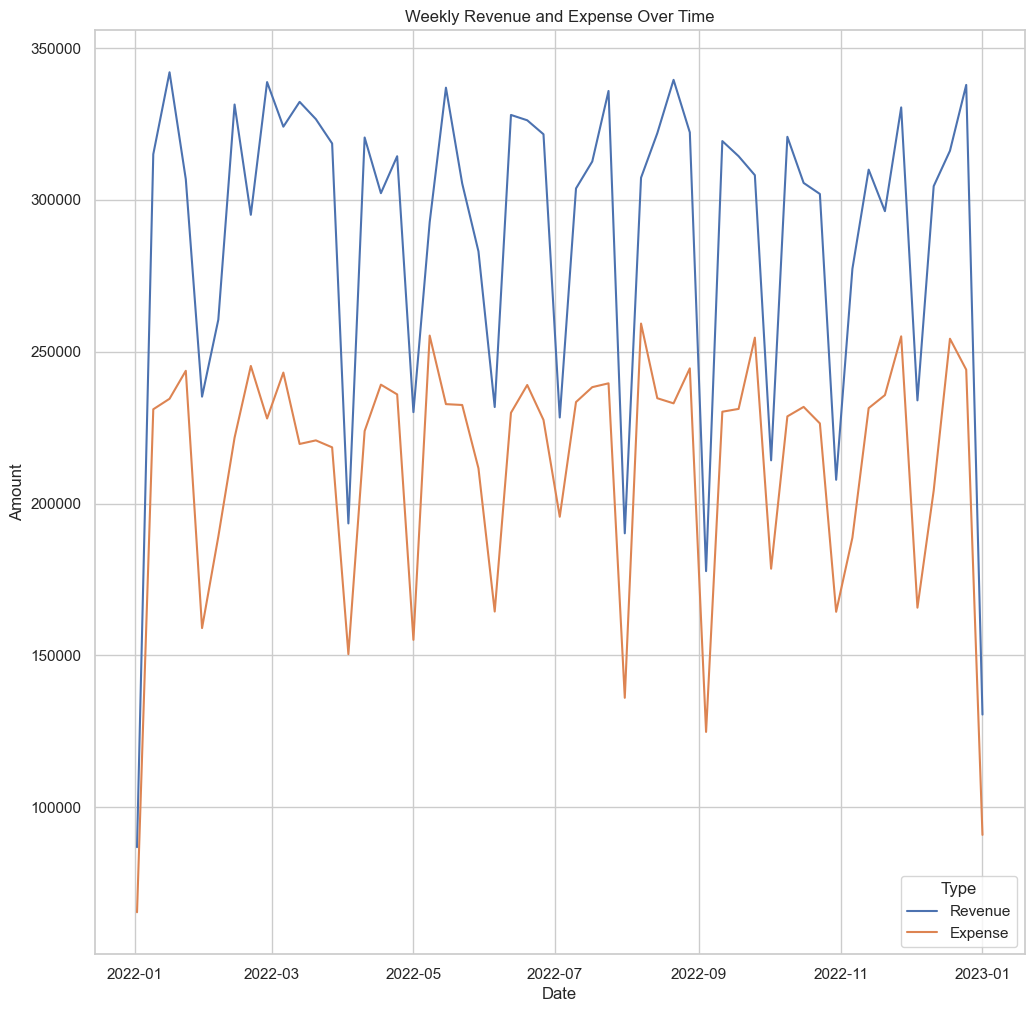

In [30]:
df_trend = df.copy()
df_trend['Date'] = pd.to_datetime(df_trend['Date'])
df_trend.set_index('Date', inplace=True)

revenue_df = df_trend[df_trend['Category'] == 'Revenue']
expense_df = df_trend[df_trend['Category'] == 'Expense']
daily_revenue = revenue_df.resample('W').sum()['Credit']
daily_expense = expense_df.resample('W').sum()['Debit']

combined_df = pd.DataFrame({'Revenue': daily_revenue, 'Expense': daily_expense}).fillna(0)
combined_df = combined_df.reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 12))
sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(combined_df, ['Date']))
plt.title('Weekly Revenue and Expense Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend(title='Type')
plt.show()

### Are sales increasing? Are expenses growing faster than revenue?

#### Perform Linear Regression Test

In [31]:
combined_df['Day'] = (combined_df['Date'] - combined_df['Date'].min()).dt.days
slope_revenue, intercept_revenue, r_value_revenue, p_value_revenue, std_err_revenue = stats.linregress(combined_df['Day'], combined_df['Revenue'])

print("Revenue Linear Regression Results:")
print(f"Slope: {slope_revenue}, Intercept: {intercept_revenue}")
print(f"R-squared: {r_value_revenue**2}, P-value: {p_value_revenue}")
if p_value_revenue < 0.05:
    print("There is a statistically significant trend in Revenue over the year based on this linear model")
else:
    print("There is no statistically significant trend in Revenue over the year based on this linear model.")
slope_expense, intercept_expense, r_value_expense, p_value_expense, std_err_expense = stats.linregress(combined_df['Day'], combined_df['Expense'])

print("\nExpense Linear Regression Results:")
print(f"Slope: {slope_expense}, Intercept: {intercept_expense}")
print(f"R-squared: {r_value_expense**2}, P-value: {p_value_expense}")
if p_value_revenue < 0.05:
    print("There is a statistically significant trend in Expenses over the year based on this linear model")
else:
    print("There is no statistically significant trend in Expenses over the year based on this linear model.")

Revenue Linear Regression Results:
Slope: -19.33664800608197, Intercept: 291601.5559748428
R-squared: 0.0013717580259658788, P-value: 0.7923223998380757
There is no statistically significant trend in Revenue over the year based on this linear model.

Expense Linear Regression Results:
Slope: 10.133006657912308, Intercept: 210838.71580712782
R-squared: 0.0006661237913433574, P-value: 0.8544487419611057
There is no statistically significant trend in Expenses over the year based on this linear model.
